# Projekt 1
#### Mateusz Grzyb, Bartłomiej Eljasiak

In [346]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import interp
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.pipeline import make_pipeline

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import f1_score

from IPython.display import display
pd.set_option('display.max_columns', None)

## Wczytanie danych

In [347]:
raw_data=pd.read_csv('sick.csv')

# podglad surowych danych
raw_data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC,negative
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other,negative
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other,negative
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other,negative
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.00,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.10,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.70,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative


## Czyszczenie danych

### Rzutowanie str na bool

In [348]:
data=raw_data.copy()

# sex (F == 1, M == 0)
data.loc[:, 'sex']=(data.loc[:, 'sex']=='F').astype(int)

# Class (Sick == 1, negative == 0)
data.loc[:, 'Class']=(data.loc[:, 'Class']=='sick').astype(int)

# pozostałe zmienne (t == 1, f == 0)
variables=set(list(data.columns))-set(['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG', 'referral_source', 'Class']) 

for variable in variables:
    data.loc[:, variable]=(data.loc[:, variable]=='t').astype(int)

### Usunięcie redundantnych kolumn

In [349]:
# jezeli pomiaru nie bylo to jego wynik jest NaN, jesli byl, to nie jest NaN
variables=['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
variables=np.core.defchararray.add(variables, np.repeat('_measured', len(variables)))

data=data.drop(variables, axis=1)

### Usunięcie kolumny bez danych

In [350]:
# kolumna TBG nie zawiera ani jednego pomiaru
data=data.drop('TBG', axis=1)

### Błędne dane

In [351]:
# najdluzej zyjacy czlowiek zyl 122 lata (a tutaj jeden ma 455...)
data.loc[data.age==455, 'age']=45

## Wyczyszczone dane (z brakami, bez kodowania)

In [352]:
# podglad wyczyszczonych danych
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0,SVHC,0
1,23.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN,other,0
2,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0,other,0
3,70.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN,other,0
4,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0,SVI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,other,0
3768,68.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2.1,124.0,1.08,114.0,SVI,0
3769,74.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.10,1.8,112.0,1.07,105.0,other,0
3770,72.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.70,2.0,82.0,0.94,87.0,SVI,0


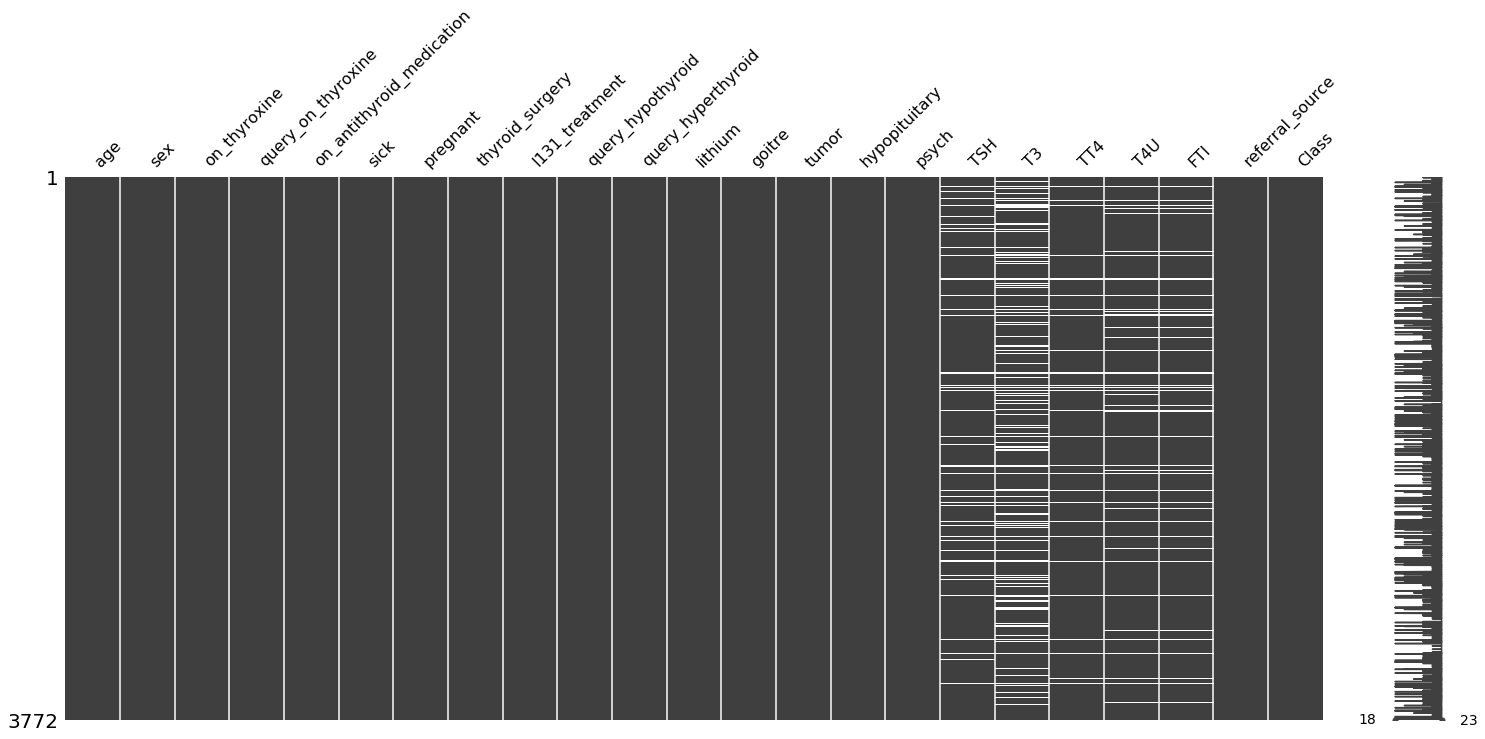

In [353]:
# podglad brakow w wyczyszczonych danych
msno.matrix(data);

## Kodowanie, imputacja i uczenie maszynowe
### Kodowanie i dyskusja
Jedyną niebinarną zmienną kategoryczną, a zatem wymagającą kodowania, jest referral_source. Sprawdźmy najpierw, czy jest ona powiązana ze zmienną celu:

In [354]:
# test chi2
data_crosstab = pd.crosstab(data['referral_source'], data['Class'], margins = False)
chi2_contingency(data_crosstab)[1]

5.919525085432426e-75

Jak widać, występuje silne powiązanie. Możnaby jednak zastanawiać się, czy algorytm powinien brać pod uwagę tę zmienną. Zmienna ta informuje nas, z jakiego źródła pochodzą dane pacjenta. Oznacza to, że uwzględniając ją, algorytm będzie przewidywał chorobę patrząc nie tylko na bieżące wyniki danego pacjenta, ale także na historię innych pacjentów, którzy badali się w tej samej placówce. Na ten moment, nie będziemy usuwali tej zmiennej. W celu jej zakodowania użyjemy kodowania One-Hot.

In [355]:
ohe=OneHotEncoder(sparse=False)

temp=pd.DataFrame(ohe.fit_transform(data[['referral_source']]))
temp.columns=ohe.get_feature_names(['referral_source'])

data=pd.concat([data, temp], axis=1)
data=data.drop('referral_source', axis=1)
# zmiana kolejnosci kolumn
cols=data.columns.tolist()
cols=cols[:21]+cols[22:]+[cols[21]]
data=data[cols]

# podglad danych po kodowaniu
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Class
0,41.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0,0.0,1.0,0.0,0.0,0.0,0
1,23.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0
2,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0,0.0,0.0,0.0,0.0,1.0,0
3,70.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0
4,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0
3768,68.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2.1,124.0,1.08,114.0,0.0,0.0,0.0,1.0,0.0,0
3769,74.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.10,1.8,112.0,1.07,105.0,0.0,0.0,0.0,0.0,1.0,0
3770,72.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.70,2.0,82.0,0.94,87.0,0.0,0.0,0.0,1.0,0.0,0


### Strategia kroswalidacji i dobór algorytmów

Użyjemy kroswalidacji KFold Stratified. Tworzy ona podział na k części zbioru oryginalnego, jednak, w przeciwieństwie do standardowej metody, kładzie mocny nacisk na to, by każda klasa była równomienie reprezentawana w każdej części.

Algorytmy, które przetestujemy to Random Forest (z racji na dużą ilość zmiennych kategorycznych) oraz XGBoost (z racji na jego popularność). Posłużymy się domyślnymi parametrami.

### Użyte miary

* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* https://en.wikipedia.org/wiki/F1_score

$F1=2\cdot\frac{precision\cdot recall}{precision+recall}$

$precision=\frac{TP}{TP+FP}$

$recall=\frac{TP}{TP+FN}$

### Funkcje testujące

In [356]:
def cv_roc(cv, classifier, X, y, ax):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train, ], y.iloc[train, ])
        w = classifier.predict(X.iloc[test, ])
        viz=plot_roc_curve(classifier, X.iloc[test, ], y.iloc[test, ], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
        interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr+std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr-std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic")
    ax.legend(loc="lower right")

In [357]:
def cv_f1(cv, classifier, X, y, ax):
    f1s = []
    
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train, ], y.iloc[train, ])
        f1 = f1_score(y.iloc[test, ], classifier.predict(X.iloc[test, ]), zero_division=1)
        f1s.append(f1)
        ax.scatter(x=1, y=f1, label=r'F1 fold %i (F1 = %0.2f)' % (i, f1), alpha=.3)
       
    ax.boxplot(f1s, widths=.8)
    ax.scatter(x=1, y=np.mean(f1s), color='b', label=r'Mean F1 (F1 = %0.2f $\pm$ %0.2f)' % (np.mean(f1s), np.std(f1s)), alpha=.8, s=80)
    ax.set(ylim=[-0.05, 1.05], xlim=[0, 3.5], title="F1 Score", ylabel='F1 Score')
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.legend(loc="lower right")

### Usunięcie wybrakowanych kolumn i Random Forest

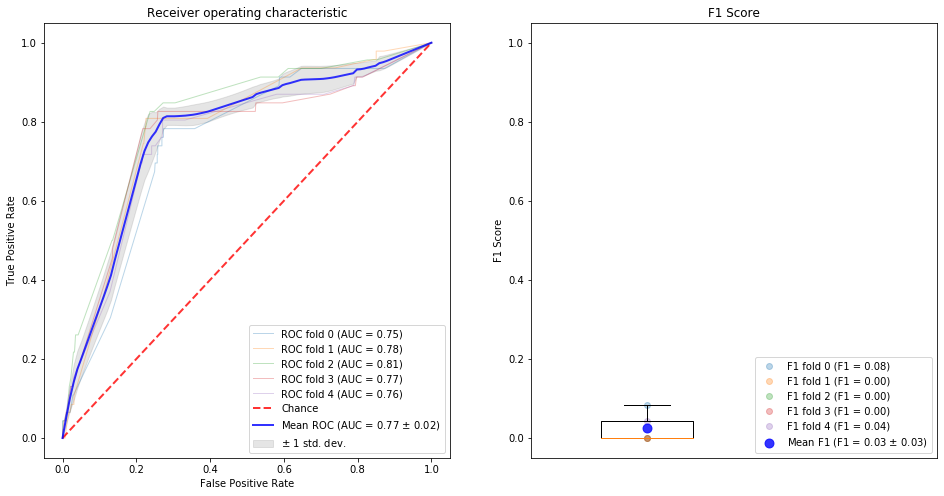

In [358]:
cut_data=data.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=RandomForestClassifier(random_state=1)
X=cut_data.drop('Class', axis=1)
y=cut_data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Usunięcie wybrakowanych kolumn i XGBoost

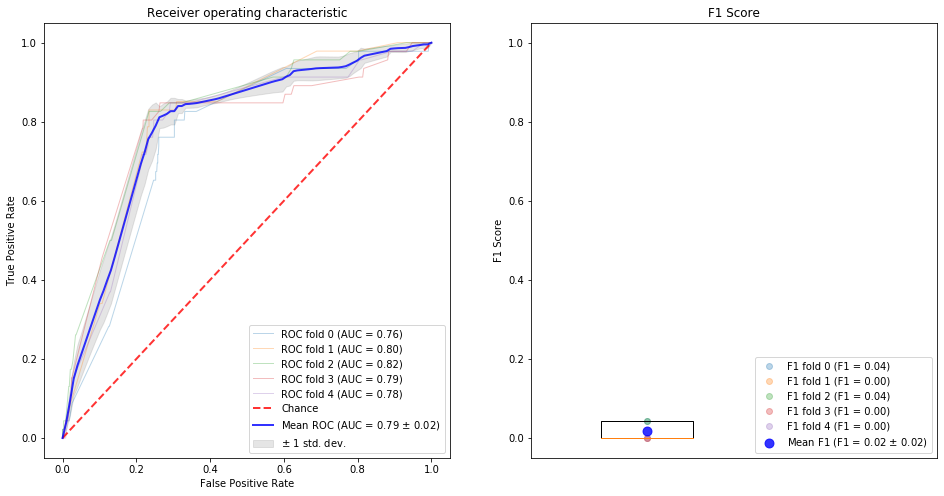

In [359]:
cut_data=data.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=XGBClassifier(random_state=1)
X=cut_data.drop('Class', axis=1)
y=cut_data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i Random Forest

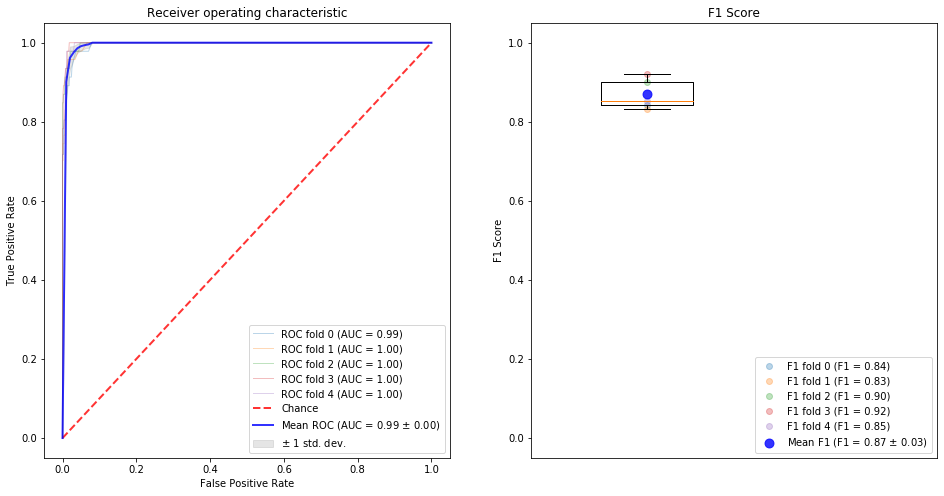

In [360]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, rf)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i XGBoost

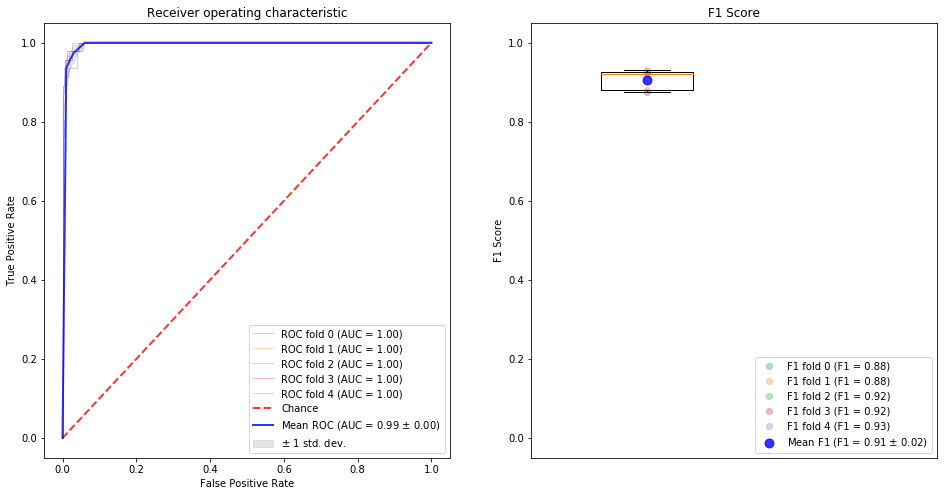

In [361]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, xgb)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i Random Forest

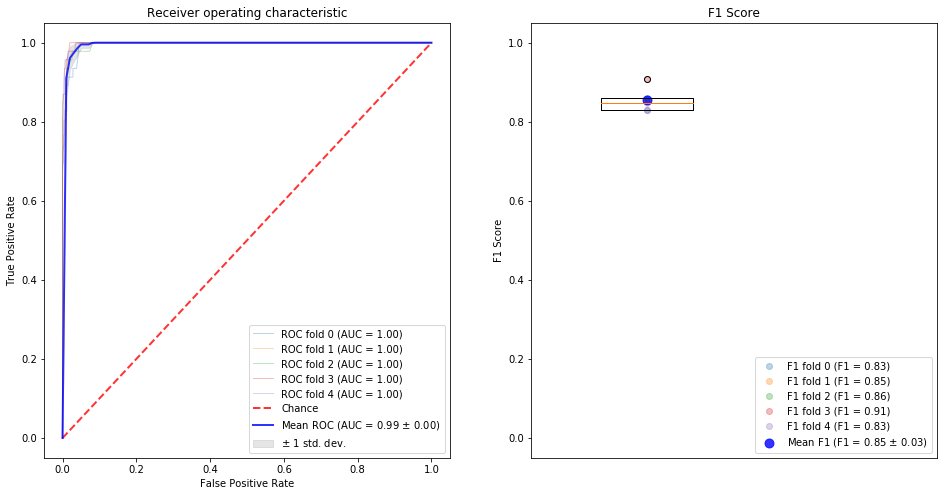

In [362]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, rf)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i XGBoost

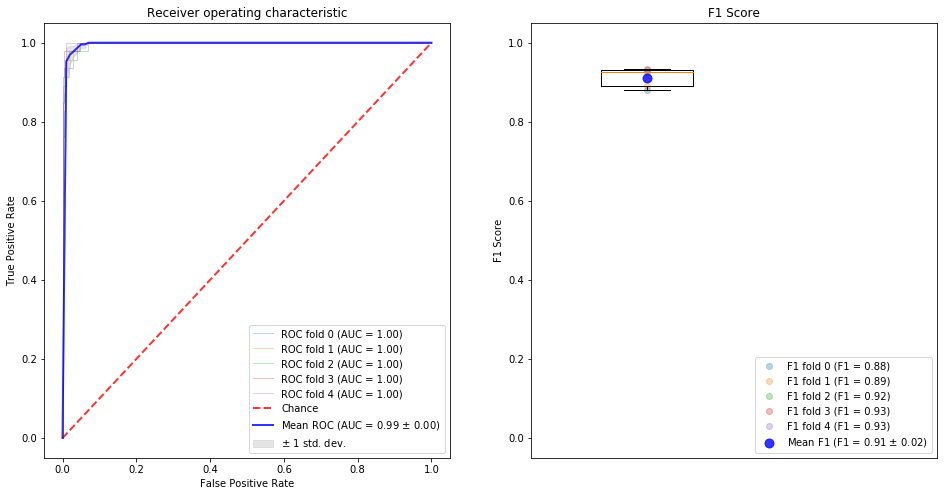

In [363]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, xgb)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i Random Forest

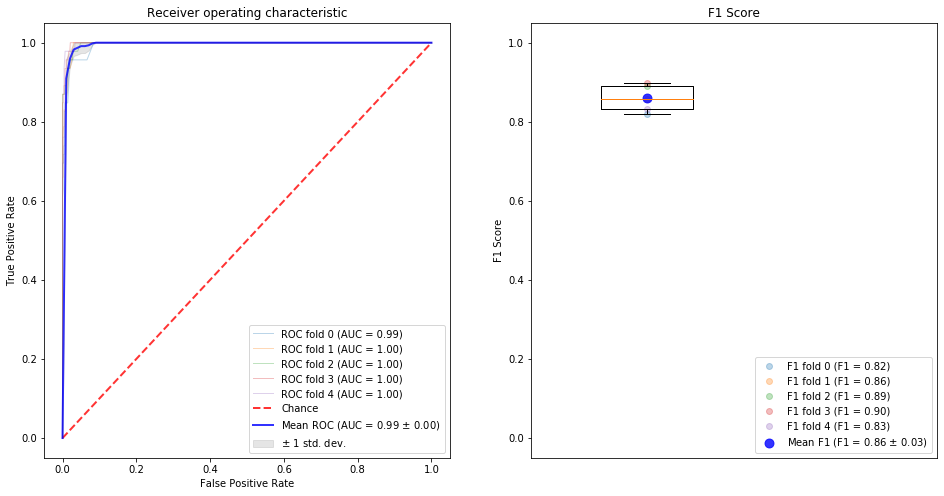

In [364]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
imp=IterativeImputer(max_iter=50)
classifier=make_pipeline(imp, rf)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i XGBoost

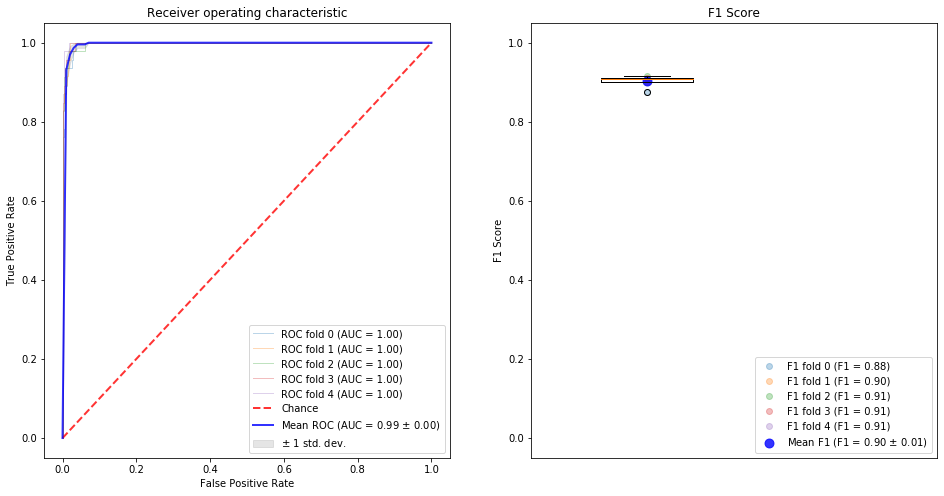

In [365]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
imp=IterativeImputer(max_iter=50)
classifier=make_pipeline(imp, xgb)
X=data.drop('Class', axis=1)
y=data['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

## Odrzucenie zmiennej referral_source
Odnosząc się do dyskusji, która powstała przy kodowaniu zmiennej referral_source, wykonamy teraz uczenie maszynowe, po jej uprzednim usunięciu z danych.

In [366]:
less_data_1=data.drop([c for c in data.columns if c[:8]=='referral'], axis=1)
less_data_1

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,41.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.30,2.5,125.0,1.14,109.0,0
1,23.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.10,2.0,102.0,NaN,NaN,0
2,46.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109.0,0.91,120.0,0
3,70.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175.0,NaN,NaN,0
4,70.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61.0,0.87,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,0
3768,68.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,2.1,124.0,1.08,114.0,0
3769,74.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.10,1.8,112.0,1.07,105.0,0
3770,72.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.70,2.0,82.0,0.94,87.0,0


### Usunięcie wybrakowanych kolumn i Random Forest

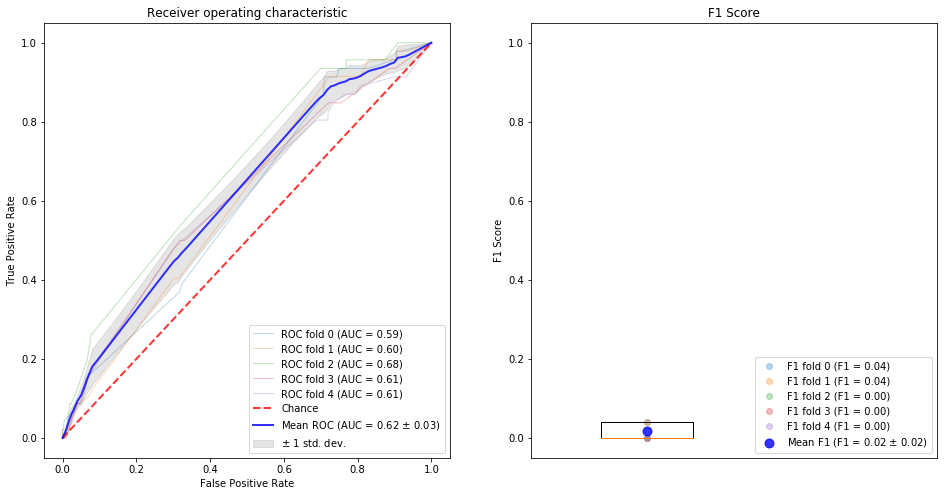

In [367]:
cut_less_data_1=less_data_1.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=RandomForestClassifier(random_state=1)
X=cut_less_data_1.drop('Class', axis=1)
y=cut_less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Usunięcie wybrakowanych kolumn i XGBoost

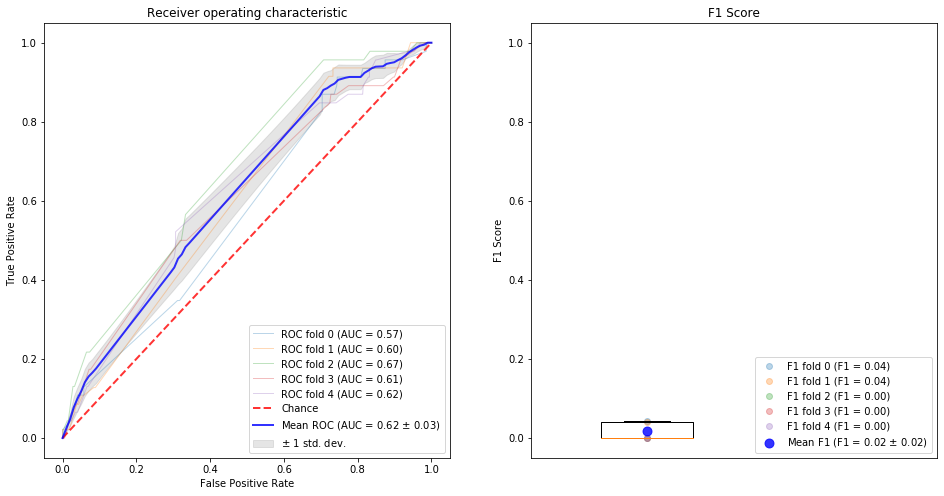

In [368]:
cut_less_data_1=less_data_1.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=XGBClassifier(random_state=1)
X=cut_less_data_1.drop('Class', axis=1)
y=cut_less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i Random Forest

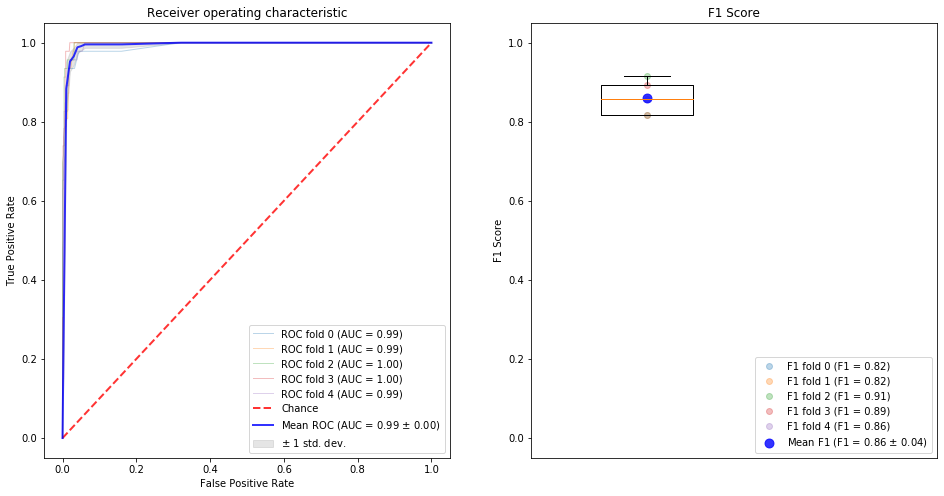

In [369]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, rf)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i XGBoost

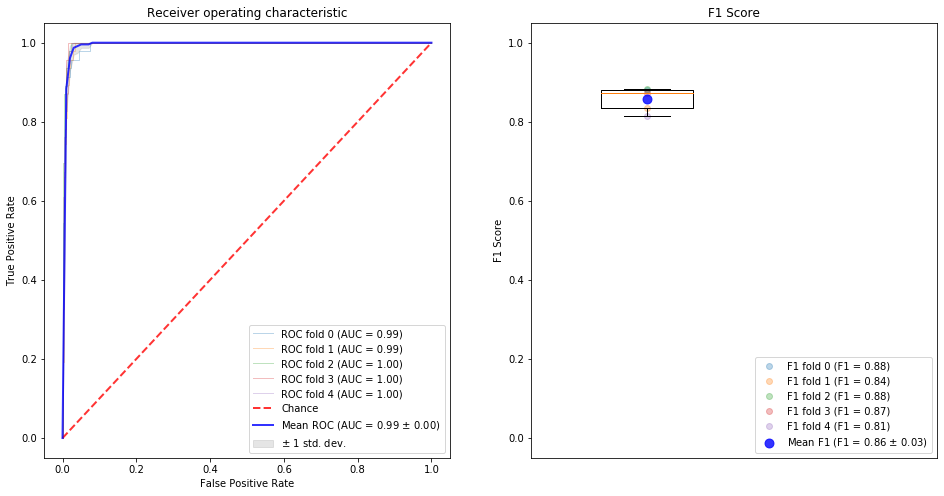

In [370]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, xgb)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i Random Forest

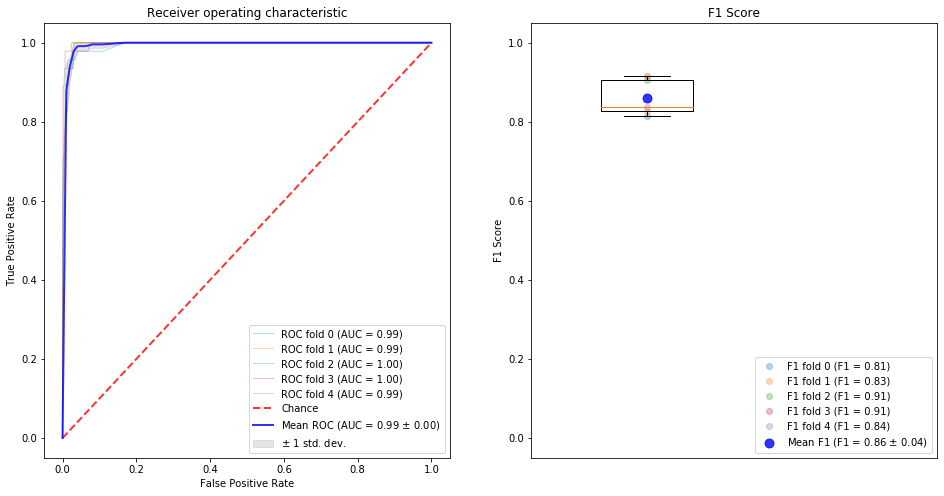

In [371]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, rf)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i XGBoost

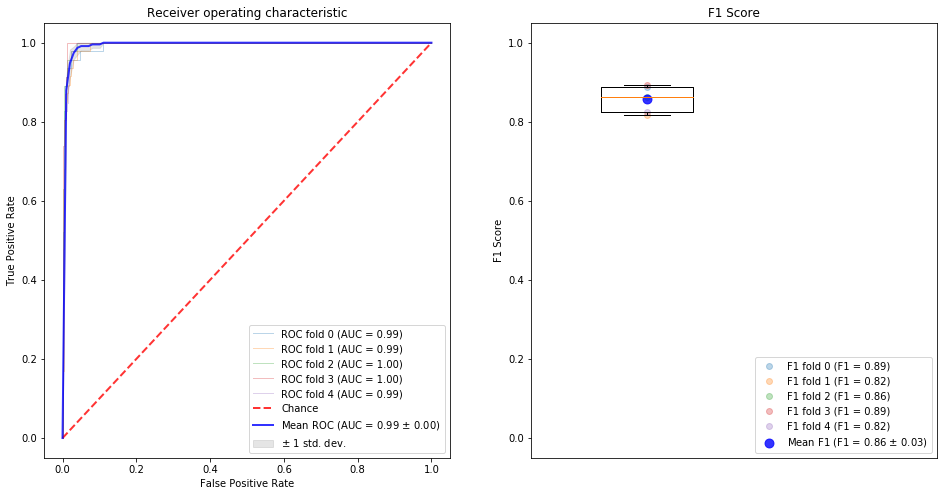

In [372]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, xgb)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i Random Forest

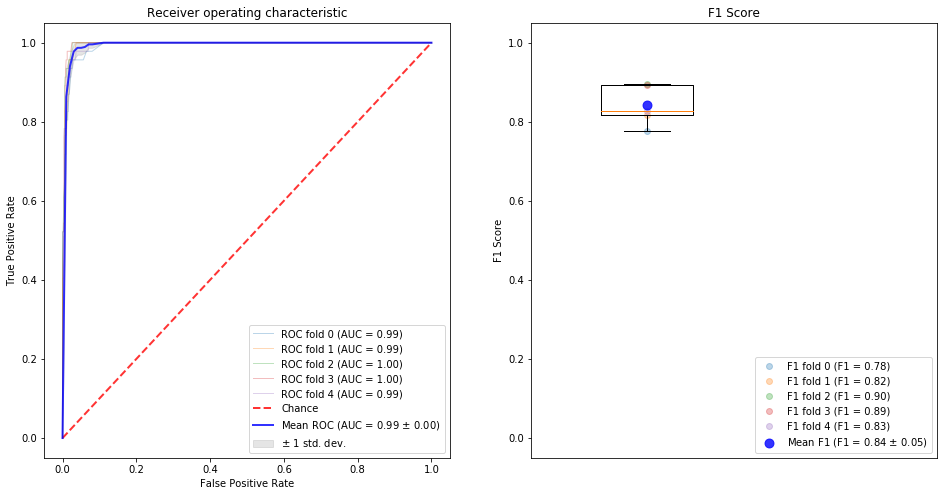

In [373]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
imp=IterativeImputer(max_iter=100)
classifier=make_pipeline(imp, rf)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i XGBoost

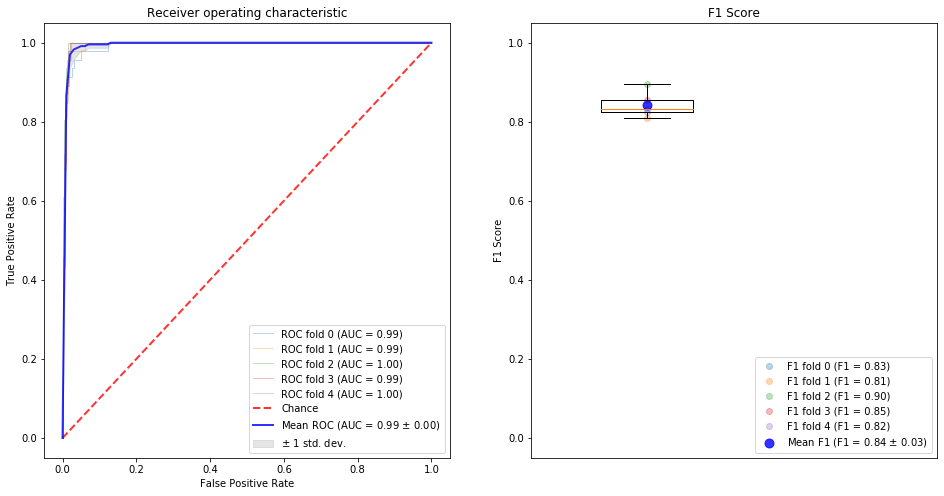

In [374]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
imp=IterativeImputer(max_iter=100)
classifier=make_pipeline(imp, xgb)
X=less_data_1.drop('Class', axis=1)
y=less_data_1['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

## Dalsza redukcja danych
Sprawdźmy teraz, za pomocą testu chi-kwadrat, jakie jeszcze zmienne są słabo powiązane ze zmienną celu i usuńmy je.

In [375]:
variables=[]

for i in less_data_1.columns:
    data_crosstab = pd.crosstab(less_data_1.loc[:, i], less_data_1['Class'], margins = False)
    p_value=chi2_contingency(data_crosstab)[1]
    if p_value<0.1:
        print('%s - POWIĄZANA' %i)
    else:
        print ('%s - NIEPOWIĄZANA' %i)
        variables.append(i)

age - POWIĄZANA
sex - POWIĄZANA
on_thyroxine - POWIĄZANA
query_on_thyroxine - NIEPOWIĄZANA
on_antithyroid_medication - NIEPOWIĄZANA
sick - POWIĄZANA
pregnant - NIEPOWIĄZANA
thyroid_surgery - NIEPOWIĄZANA
I131_treatment - NIEPOWIĄZANA
query_hypothyroid - POWIĄZANA
query_hyperthyroid - POWIĄZANA
lithium - NIEPOWIĄZANA
goitre - NIEPOWIĄZANA
tumor - NIEPOWIĄZANA
hypopituitary - POWIĄZANA
psych - NIEPOWIĄZANA
TSH - NIEPOWIĄZANA
T3 - POWIĄZANA
TT4 - POWIĄZANA
T4U - POWIĄZANA
FTI - POWIĄZANA
Class - POWIĄZANA


In [376]:
less_data_2=less_data_1.drop(variables, axis=1)
less_data_2

,age,sex,on_thyroxine,sick,query_hypothyroid,query_hyperthyroid,hypopituitary,T3,TT4,T4U,FTI,Class
0,41.0,1,0,0,0,0,0,2.5,125.0,1.14,109.0,0
1,23.0,1,0,0,0,0,0,2.0,102.0,NaN,NaN,0
2,46.0,0,0,0,0,0,0,NaN,109.0,0.91,120.0,0
3,70.0,1,1,0,0,0,0,1.9,175.0,NaN,NaN,0
4,70.0,1,0,0,0,0,0,1.2,61.0,0.87,70.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,0
3768,68.0,1,0,0,0,0,0,2.1,124.0,1.08,114.0,0
3769,74.0,1,0,0,0,1,0,1.8,112.0,1.07,105.0,0
3770,72.0,0,0,0,0,0,0,2.0,82.0,0.94,87.0,0


### Usunięcie wybrakowanych kolumn i Random Forest

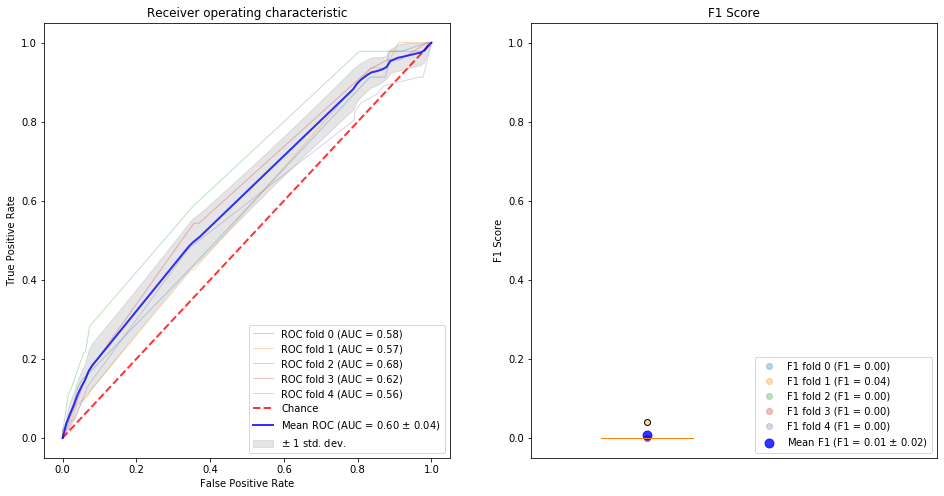

In [377]:
cut_less_data_2=less_data_2.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=RandomForestClassifier(random_state=1)
X=cut_less_data_2.drop('Class', axis=1)
y=cut_less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Usunięcie wybrakowanych kolumn i XGBoost

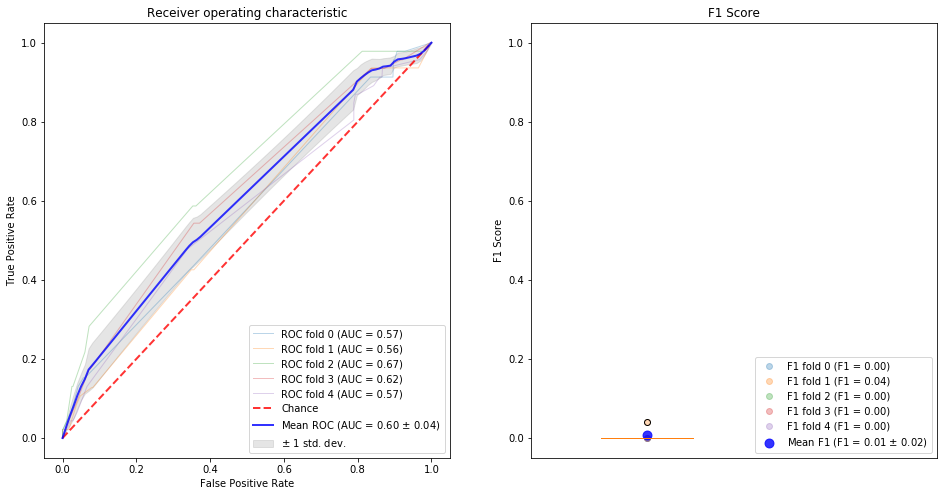

In [378]:
cut_less_data_2=less_data_2.dropna(axis=1)
cv=StratifiedKFold(n_splits=5)
classifier=XGBClassifier(random_state=1)
X=cut_less_data_2.drop('Class', axis=1)
y=cut_less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i Random Forest

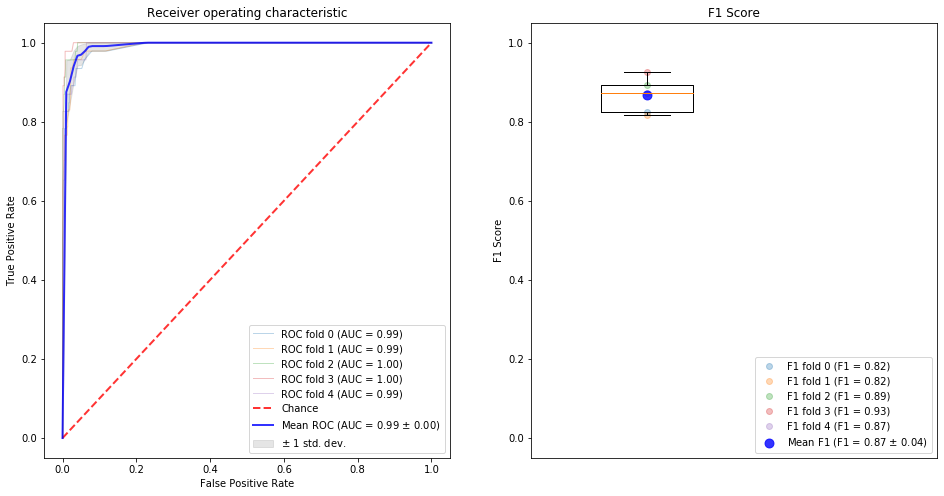

In [380]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, rf)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja średniej i XGBoost

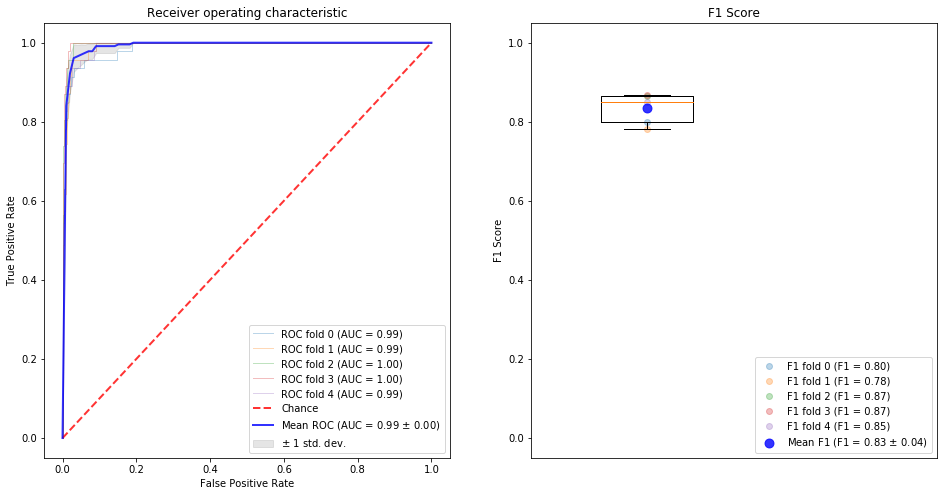

In [381]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='mean')
classifier=make_pipeline(mi, xgb)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i Random Forest

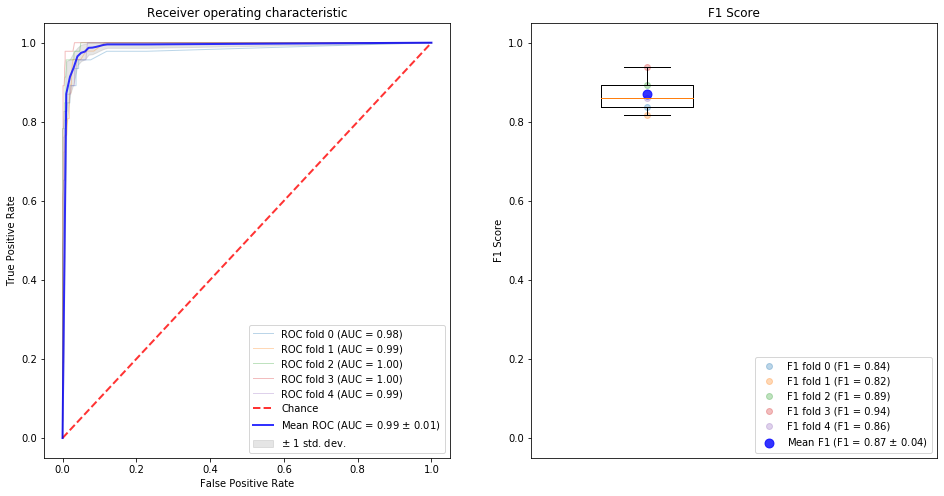

In [382]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, rf)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Imputacja mediany i XGBoost

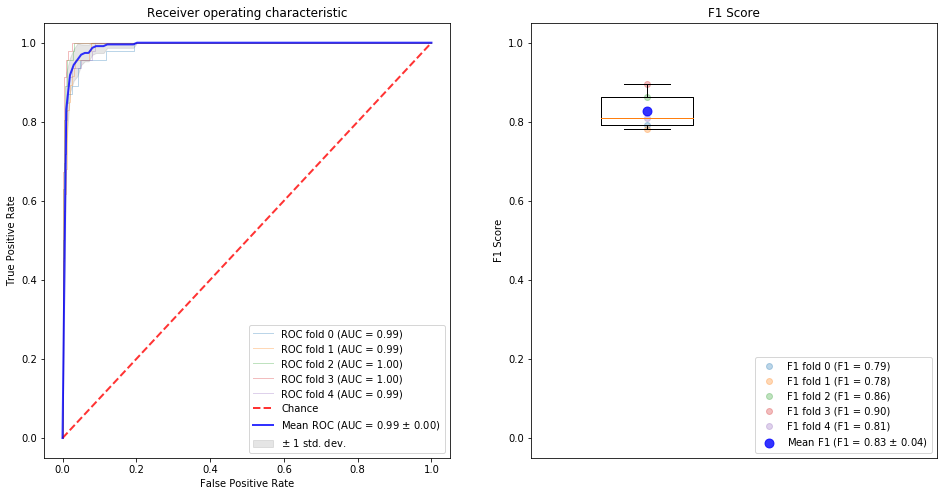

In [384]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
mi=SimpleImputer(strategy='median')
classifier=make_pipeline(mi, xgb)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i Random Forest

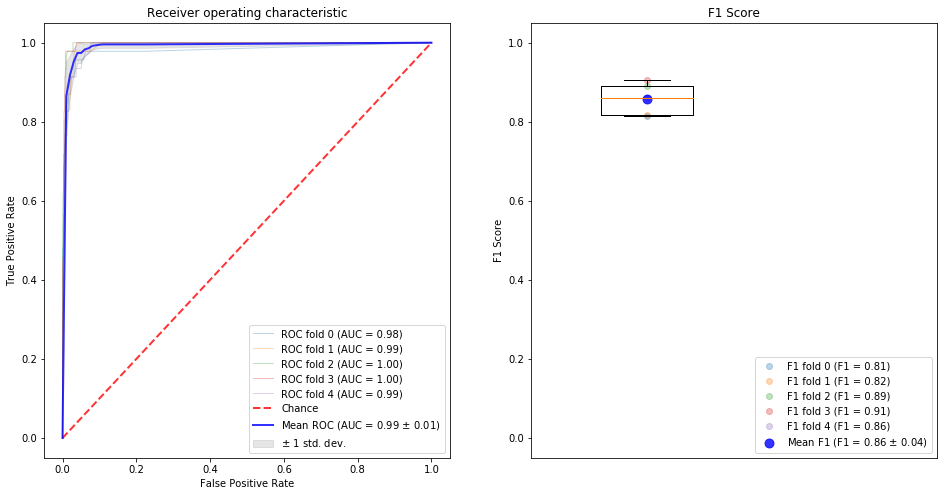

In [385]:
cv=StratifiedKFold(n_splits=5)
rf=RandomForestClassifier(random_state=1)
imp=IterativeImputer(max_iter=100)
classifier=make_pipeline(imp, rf)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

### Iterative Imputer i XGBoost

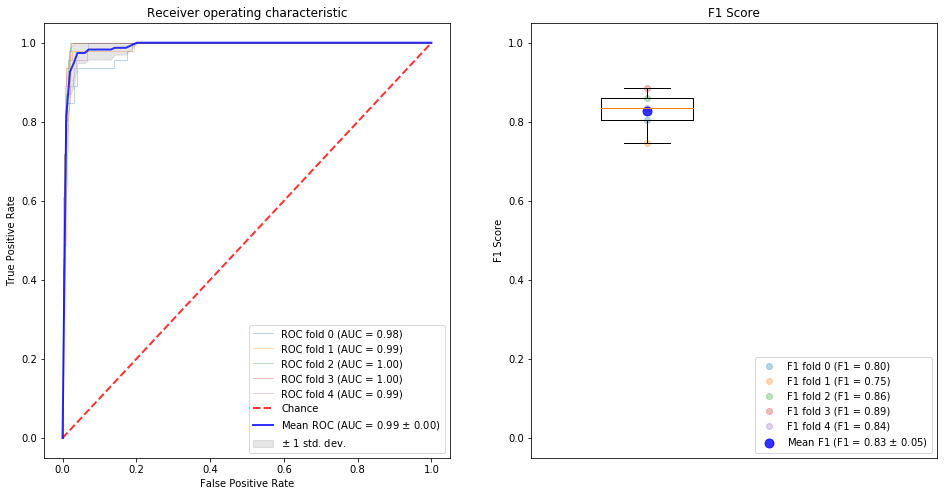

In [386]:
cv=StratifiedKFold(n_splits=5)
xgb=XGBClassifier(random_state=1)
imp=IterativeImputer(max_iter=100)
classifier=make_pipeline(imp, xgb)
X=less_data_2.drop('Class', axis=1)
y=less_data_2['Class']

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
cv_roc(cv, classifier, X, y, ax1)
cv_f1(cv, classifier, X, y, ax2)

## Podsumowanie wyników
Szybkie podsumowanie, w punktach:

* Wyniki kroswalidacji wykazały poprawność metodyki,



* najlepsze wyniki w ogóle uzyskał XGBoost z imputacją mediany/średniej,
* najlepsze wyniki dla danych bez zmiennej referral_source uzyskały Random Forest/XGBoost z imputacją mediany,
* najlepsze wyniki dla zredukowanych danych uzyskał Random Forest z imputacją mediany/średniej,


* choć przy usuwaniu wybrakowanych kolumn AUC było zauważalnie większe niż 0.5, to F1 wykazało, że algorytm nie wykrywał prawie żadnych True Positive (proporcje klas są mocno zachwiane, co ma tutaj znaczenie), 
* usunięcie zmiennej referral_source, słuszność obecności której jest wątpliwa, w połączeniu z imputacją(średniej/mediany lub Iterative Imputer) jedynie lekko pogarsza wyniki,
* wymiarowość danych można znacznie zredukować i wciąż uzyskać bardzo dobre wyniki,
* Iterative Imputer nie okazał się najlepszą metodą imputacji,
* XGBoost jest szybszy od Random Forest